# <img style="float: left; padding-right: 10px; width: 200px" src="https://raw.githubusercontent.com/trivikverma/researchgroup/master/assets/media/logo.png"> EPA-1316 Introduction to *Urban* Data Science 


## Assignment 3: Prediction / Inference

**TU Delft**<br>
**Q1 2021**<br>
**Instructor:** Trivik Verma <br>
**TAs:**  Auriane Técourt, Luka Janssens, Marya El Malki, Mobeen Nawaz, Stephan Olde, Ruth Nelson, Juliana Gonçalves <br>
**[Centre for Urban Science & Policy]( https://cusp.tbm.tudelft.nl/)** <br>

**Done by:** Raquel Romão, student number 5629608


---



## From Assignment 2

(Assignment 3 starts bellow)

Taking into account the feedback from assignment 2, I adjusted some details in the plots, deleted extra figures and changed some lines of code. However, I chose to keep the EDA similar for the further analysis in assignment 3.

# ``Analysis``

I hypothesize that the neighbourhoods of The Hague with `higher average incomes` are more prone to `emit CO2`. Later, I also analysed if the bike lane length per neighbourhood could be related to it, hypotesizing that a bigger amount of `bike lanes` available could translate in a minor use of transportation by motorized vehicles and therefore a minor CO2 emission. For my analysis, I selected the year of 2016 (year available for the CO2 emissions parameter).

I used the following metrics:
 * Average personal income per resident [euros]
 * CO2 per neighbourhood per year (kton)
 * Bike lane length (km)

It was based on this that I proceeded with my analysis.

In [1]:
#Imports the necessary libraries
import os             
import pandas as pd
import numpy as np
import palettable as pltt
import seaborn as sns
import matplotlib.pyplot as plt
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

import osmnx as ox, geopandas as gpd
%matplotlib inline
ox.config(log_console=True, use_cache=True)

import matplotlib.style as style 
style.use('seaborn-colorblind') 

C:\Users\UX430U\anaconda3\envs\gds\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


1. As it was suggested I used two datasets: merged 1 shapefile (already provided) and a csv file (that I found and obtained)

After looking up in [Den Haag Cijfers](https://denhaag.incijfers.nl/jive), I selected the variables I wanted to work with and downloaded the respective csv file.

In [2]:
#To load and read the dataset obtained from Den Haag Cijfers
d = 'data/NeighbourhoodsData.csv'

df = pd.read_csv(d, index_col=0)

In [3]:
df.head()

,CO2 per neighbourhood per year (kton)|2006,Average personal income per resident|2006
Buurten,,
01 Oud Scheveningen,3.6,18000
02 Vissershaven,3.0,19000
03 Scheveningen Badplaats,7.3,23400
04 Visserijbuurt,4.5,20400
05 v Stolkpark/Schev Bosjes,1.0,36600


In [4]:
#To load the provided shape file
shp_dir = 'data/neighborhoods.shp'

shp = gpd.read_file(shp_dir)

In [5]:
shp.head()

,neighb_cbs,neigb_cijf,geometry
0,Oostduinen,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ..."
1,Belgisch Park,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ..."
2,Westbroekpark,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ..."
3,Duttendel,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ..."
4,Nassaubuurt,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ..."


In [6]:
#To obtain the columns names
shp.columns

Index(['neighb_cbs', 'neigb_cijf', 'geometry'], dtype='object')

In [7]:
#To exclude the column relative to cbs dataset, since it is not the one used
shp = shp.drop('neighb_cbs', axis=1)
shp.head()

,neigb_cijf,geometry
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ..."
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ..."
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ..."
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ..."
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ..."


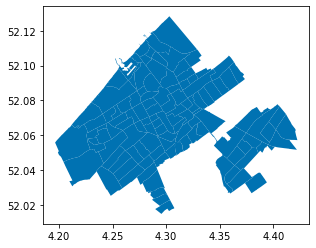

In [8]:
fig = shp.plot()

#To avoid having text surrounding the plot
for txt in fig.texts:
    txt.set_visible(False)

In [9]:
#To merge the shapefile and the csv file, by neighbourhood
data = shp.join(df, on='neigb_cijf')
data.head()

,neigb_cijf,geometry,CO2 per neighbourhood per year (kton)|2006,Average personal income per resident|2006
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,-
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300


2. Then, I cleaned my data and made it tabular.

In [10]:
#rename columns to more accessible names
data = data.rename(columns={'neigb_cijf': 'neigb', 'CO2 per neighbourhood per year (kton)|2006': 'CO2', 'Average personal income per resident|2006': 'income'})

After renaming the columns to more acessible names, I looked for missing values.

In [11]:
print('Missing values neigb:', np.sum([data.neigb.isnull()]))
print('Missing values geometry:', np.sum([data.geometry.isnull()]))
print('Missing values CO2:', np.sum([data.CO2.isnull()]))
print('Missing values income:', np.sum([data.income.isnull()]))

Missing values neigb: 0
Missing values geometry: 0
Missing values CO2: 0
Missing values income: 0


I came to the conclusion that the values that were not available in the dataset from Den Haag Cijfers were replaced with a '-', so taking this into account I tried to get a sense of how many missing values there are for each column.

In [12]:
#Missing values for each column
print('Missing values neigb:', np.sum([data.neigb == '-']))
print('Missing values geometry:', np.sum([data.geometry.isnull()]))
print('Missing values CO2:', np.sum([data.CO2 == '-']))
print('Missing values income:', np.sum([data.income == '-']))

Missing values neigb: 0
Missing values geometry: 0
Missing values CO2: 4
Missing values income: 8


To make it possible to manage them later, I opted to replace them for NaN's:

In [13]:
data = data.replace(['-'], np.nan)
data.head()

,neigb,geometry,CO2,income
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,NaN
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300


Afterwards, I tried to get a sense of the df data types:

In [14]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   neigb     114 non-null    object  
 1   geometry  114 non-null    geometry
 2   CO2       110 non-null    object  
 3   income    106 non-null    object  
dtypes: geometry(1), object(3)
memory usage: 3.7+ KB


I converted the dtype of the `CO2` and `income` columns to numeric values, since I don't want to work with objects.

In [15]:
#Convert the object dtypes columns to numeric values
data[["CO2", "income"]] = data[["CO2", "income"]].apply(pd.to_numeric)
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   neigb     114 non-null    object  
 1   geometry  114 non-null    geometry
 2   CO2       110 non-null    float64 
 3   income    106 non-null    float64 
dtypes: float64(2), geometry(1), object(1)
memory usage: 3.7+ KB


Since I am working with so little cases and variables, I opted to keep all of them and replace the missing values with the respective column average.

In [16]:
#Replaces the missing values with the respective column average
for i in ['CO2', 'income']:  
    data[i].fillna(value=data[i].mean(),inplace=True)
    
data.head()

,neigb,geometry,CO2,income
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000


One of the rows belonging do the neigb column has its entrie as "Unknown" and since it doens't make sense to analise something unknow, I chose to remove this case from the data.

In [17]:
#To select only the cases not named 'Unknown'
data=data[data.neigb != 'Unknown']
data.head()

,neigb,geometry,CO2,income
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000


In [18]:
#To set as index the neighbourhood's column
data=data.set_index('neigb')
data.head()

,geometry,CO2,income
neigb,,,
70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566
71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000
73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000
74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000
48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000


3. Afterwards, I carried out an exploratory data analysis (EDA).

First of all, to make the interpretation of the data more clear, I decided to divide the values of each variable in 4 groups, similarly to what appears in the Den Haag in Cijfers website: Lower, Average, Higher and Much Higher.

The range of values for each group are as follows (taking into account the mean in the cell below [obtained by the `describe()` function] and the website's values for each group):

* Lower Income  -  smaller or equal to `16000`;
* Average Income  - ` ]16000, 23000]`;
* Higher  -  `]23000, 29000]`;
* Much Higher  -  bigger than `29000`.

In [19]:
data.describe()

,CO2,income
count,114.000000,114.000000
mean,4.459091,22284.905660
std,3.073158,8366.344212
min,0.000000,9400.000000
25%,2.300000,15825.000000
50%,3.850000,21050.000000
75%,6.275000,25575.000000
max,14.200000,51000.000000


In [20]:
#To add a column with the income group in which each neighbourhood is included 
income_group = []
for row in data['income']:
    if row <= 16000 :    income_group.append('Lower')
    elif (row > 16000) & (row <= 23000):   income_group.append('Average')
    elif (row > 23000) & (row <= 29000):  income_group.append('Higher')
    elif row > 29000:  income_group.append('Much Higher')
            
data['income_group'] = income_group
data.head()

,geometry,CO2,income,income_group
neigb,,,,
70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566,Average
71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000,Higher
73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000,Much Higher
74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000,Much Higher
48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000,Much Higher


It was only then that I started graphing, taking into account the principals for graphic excellence (named below each plot).

#### Histograms

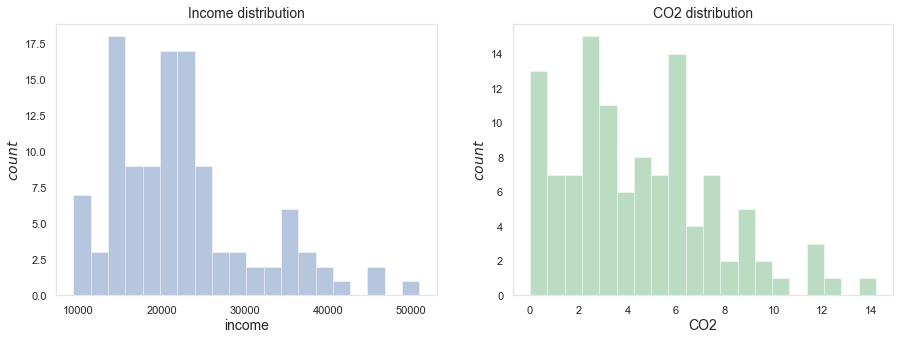

In [21]:
#To plot an histogram for each variable 
sns.set(color_codes=True)

fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.set(font_scale=0.5)

colors = ['b','g']
title = ['Income distribution', 'CO2 distribution']
variables = ['income', 'CO2']

#To plot each variable and personalize the histogram
for i in range(len(variables)):
    sns.distplot(data[variables[i]], kde=False, bins=20, ax=ax[i], color=colors[i]);
    ax[i].set_title(title[i], fontsize=14)
    ax[i].set_xlabel(variables[i], fontsize=14)
    ax[i].set_ylabel(r'$count$', fontsize=14)
    ax[i].grid(False)
    ax[i].set_facecolor('w')
    ax[i].spines['bottom'].set_color('0.9')
    ax[i].spines['left'].set_color('0.9')
    ax[i].spines['top'].set_color('0.9')
    ax[i].spines['right'].set_color('0.9')

For this figure I used the following principals for graphic excellence:

 * Encourage the eye to compare different pieces of data.
 * Present data in a way to facilitate comparisons.
 * Make efficient use of space.

Then, I tried to include the `income_groups` variable in a histogram.

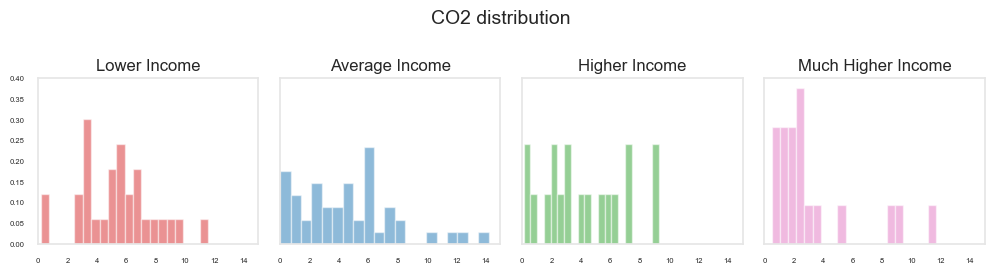

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)

colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink'] 
group_title = ['Lower Income', 'Average Income', 'Higher Income', 'Much Higher Income']

#To group the data by income group
x1 = data.loc[data.income_group == 'Lower', 'CO2']
x2 = data.loc[data.income_group == 'Average', 'CO2']
x3 = data.loc[data.income_group == 'Higher', 'CO2' ]
x4 = data.loc[data.income_group == 'Much Higher', 'CO2']
lx =[x1,x2,x3,x4]

#To plot the data respective to each income group and personalize each histogram
for i in range(len(colors)):
    x=lx[i]
    ax[i].hist(x, alpha=0.5, bins=20, density=True, stacked=True, label=group_title[i], color=colors[i], edgecolor='w', linewidth=1) 
    ax[i].set_title(group_title[i], fontsize=12)
    ax[i].set_xlim(0, 15); ax[i].set_ylim(0, 0.4);
    ax[i].grid(False)
    ax[i].set_facecolor('w')
    ax[i].spines['bottom'].set_color('0.9')
    ax[i].spines['left'].set_color('0.9')
    ax[i].spines['top'].set_color('0.9')
    ax[i].spines['right'].set_color('0.9')

plt.suptitle('CO2 distribution', y=1.05, size=14)
plt.tight_layout();

For this figure I used the following principals for graphic excellence:

 * Present many numbers in a small space, i.e., efficiently.
 * Encourage the eye to compare different pieces of data.
 * Make efficient use of space
 * Select the best graph type
 * Present data in a way to facilitate comparisons.
 * Reveal the data at several levels of detail, from a broad overview to the fine structure.

#### Boxplot

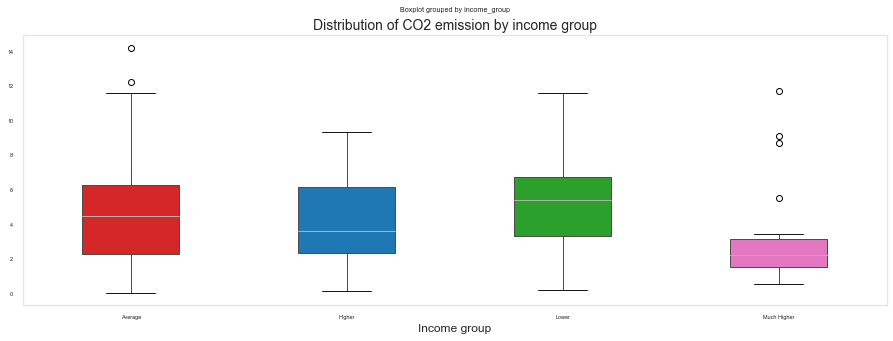

In [23]:
ax = data.boxplot(column='CO2', by='income_group', patch_artist=True, figsize=(15,5))

ax.set_title('Distribution of CO2 emission by income group', fontsize=14)
ax.set_xlabel('Income group', fontsize=12)

#To set the color for each income group
for i in range(4):
    box = ax.artists[i]
    box.set_facecolor(colors[i])
    
ax.grid(False)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('0.9')
ax.spines['left'].set_color('0.9')
ax.spines['top'].set_color('0.9')
ax.spines['right'].set_color('0.9')



For this figure I used the following principals for graphic excellence:

 * Present many numbers in a small space, i.e., efficiently.
 * Show uncertainty.
 * Encourage the eye to compare different pieces of data.
 * Present data in a way to facilitate comparisons.

#### Scatterplot

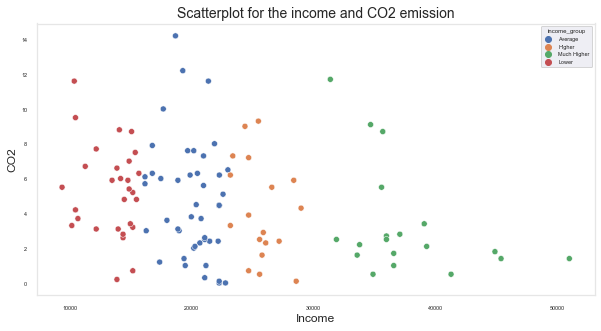

In [24]:
f, ax = plt.subplots(1,1, figsize=(10, 5))
sns.scatterplot(x="income", y="CO2", hue="income_group", data=data, ax=ax);
ax.grid(False)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('0.9')
ax.spines['left'].set_color('0.9')
ax.spines['top'].set_color('0.9')
ax.spines['right'].set_color('0.9')
ax.set_title('Scatterplot for the income and CO2 emission', fontsize=14)
ax.set_xlabel('Income', fontsize=12)
ax.set_ylabel('CO2', fontsize=12)

for txt in fig.texts:
    txt.set_visible(False)

For this figure I used the following principals for graphic excellence:

 * Present many numbers in a small space, i.e., efficiently.
 * Present data in a way to facilitate comparisons.
 * Make the dataset coherent.

#### Cloropleths

To display the CO2 emission and income per neighbourhood, I created two cloropleths.

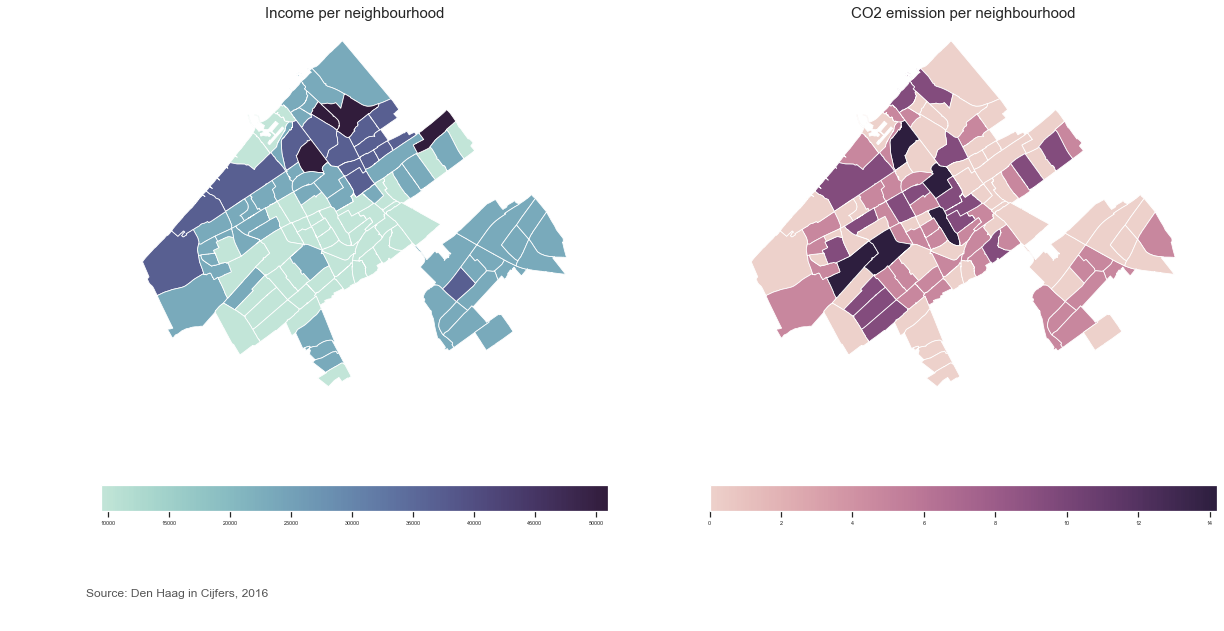

In [25]:
#Set the range for the choropleth
vmin0, vmax0 = 9400, 51000

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

data.plot(column='income', scheme='equal_interval', k=4, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), linewidth=0.8,  edgecolor='w', ax=ax[0])

#Add title to the map
ax[0].set_title('Income per neighbourhood', fontdict={'fontsize':15})

#Remove axes
ax[0].axis('off')

#Create an annotation for the data source
ax[0].annotate('Source: Den Haag in Cijfers, 2016', xy=(0.06, .06),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')


#Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), norm=plt.Normalize(vmin=vmin0, vmax=vmax0))
#Empty array for the data range
sm._A = []
#Add the colorbar to the figure
cbar = fig.colorbar(sm, orientation='horizontal', ax=ax[0])


vmin1, vmax1 = 0, 14.2

#Plot the other choropleth
data.plot(column='CO2', scheme='equal_interval', k=4, cmap=sns.cubehelix_palette(as_cmap=True), edgecolor='w', linewidth=0.8, ax=ax[1])


ax[1].set_title('CO2 emission per neighbourhood', fontdict={'fontsize':15})


ax[1].axis('off')


sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=plt.Normalize(vmin=vmin1, vmax=vmax1))

sm._A = []

cbar = fig.colorbar(sm, orientation='horizontal', ax=ax[1])

Next, I tried to find the cases that validate my hypothesis. For that, I looked for neighbourhoods with a **Higher** or **Much Higher income** as well as a **CO2 emission bigger than 7** (more or less the middle of the interval for the CO2 emissions).

In [26]:
filter_data1 = data[(data.income_group == 'Much Higher') & (data.CO2 > 7)]
filter_data1.head()

,geometry,CO2,income,income_group
neigb,,,,
46 Archipelbuurt,"POLYGON ((4.30625 52.09663, 4.30628 52.09661, ...",8.7,35700.0,Much Higher
07 Statenkwartier,"POLYGON ((4.27823 52.10228, 4.27829 52.10222, ...",11.7,31400.0,Much Higher
09 Vogelwijk,"POLYGON ((4.26475 52.09163, 4.26489 52.09151, ...",9.1,34700.0,Much Higher


In [27]:
filter_data2 = data[(data.income_group == 'Higher') & (data.CO2 > 7)]
filter_data2.head()

,geometry,CO2,income,income_group
neigb,,,,
71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.0,Higher
03 Scheveningen Badplaats,"POLYGON ((4.28401 52.11169, 4.28384 52.11158, ...",7.3,23400.0,Higher
53 Vruchtenbuurt,"POLYGON ((4.26183 52.07348, 4.26210 52.07295, ...",7.2,24700.0,Higher
66 Bezuidenhout-Oost,"POLYGON ((4.34235 52.09126, 4.34241 52.09121, ...",9.0,24400.0,Higher


Then, I defined a list to save the neighbourhoods that could be of interest.

In [28]:
interesting_neigbs=[]
interesting_neigbs.append(filter_data1.index)
interesting_neigbs.append(filter_data2.index)
interesting_neigbs

[Index(['46 Archipelbuurt', '07 Statenkwartier', '09 Vogelwijk'], dtype='object', name='neigb'),
 Index(['71 Belgisch Park', '03 Scheveningen Badplaats', '53 Vruchtenbuurt',
        '66 Bezuidenhout-Oost'],
       dtype='object', name='neigb')]

Then, I plotted the cloropleth displaying the CO2 emission per neighbourhood together with the bike lanes network to test if the CO2 emission could be related to it.

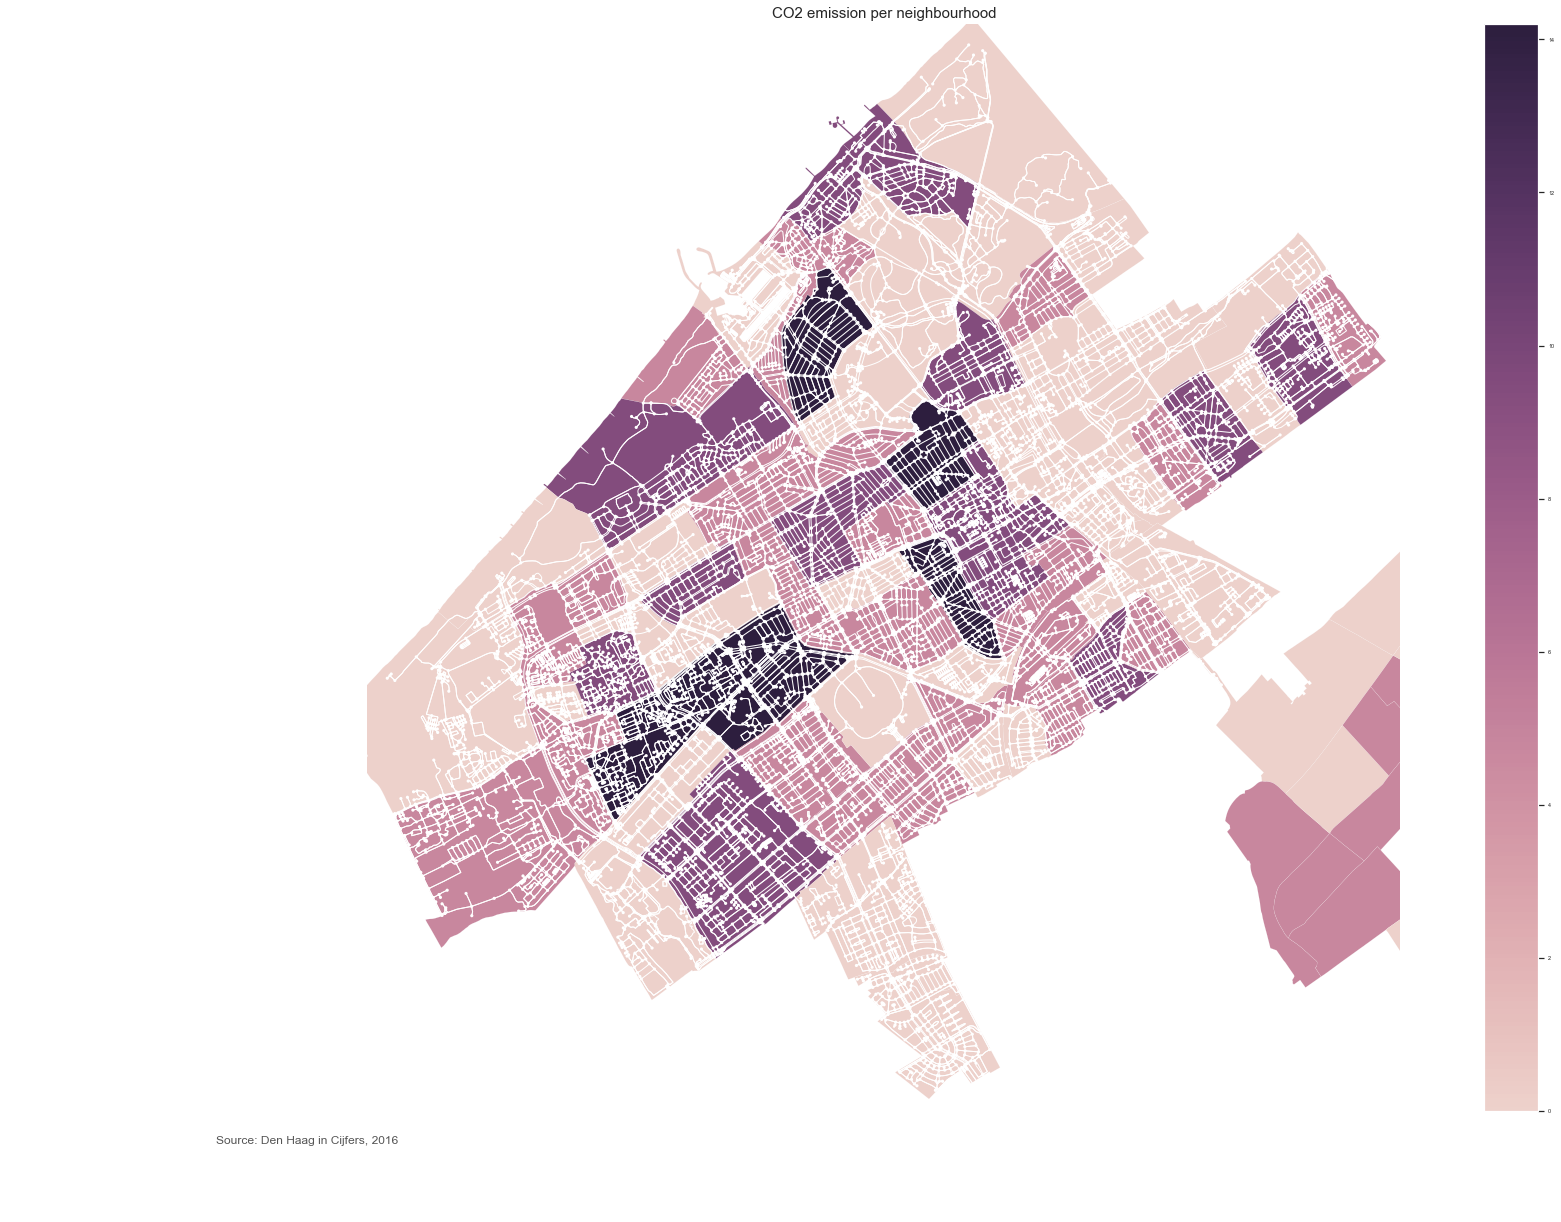

In [29]:
variable = 'CO2'
# set the range for the choropleth
vmin, vmax = 0, 14.2


fig, ax = plt.subplots(1, figsize=(30, 20))

data.plot(column=variable, scheme='equal_interval', k=4, cmap=sns.cubehelix_palette(as_cmap=True), alpha=1, edgecolor='w', linewidth=0.1, ax=ax) #legend=True?


ax.set_title('CO2 emission per neighbourhood', fontdict={'fontsize':15})


ax.axis('off')



ax.annotate('Source: Den Haag in Cijfers, 2016', xy=(0.1, .06),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')



sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=plt.Normalize(vmin=vmin, vmax=vmax))

sm._A = []

cbar = fig.colorbar(sm)

#To plot the graph with bike network
G = ox.graph_from_place('The Hague, The Netherlands', network_type='bike')
ox.plot_graph(G, node_size=10, edge_color='w', ax=ax)

for txt in fig.texts:
    txt.set_visible(False)

To measure the amount of bike lanes per neighbourhood, I used the *osmnx* `basic_stats` function in order to get their length.

In [30]:
polygon = data['geometry']

In [31]:
stats = []

#To create a list with a dictionary with the stats for each polygon
for pol in polygon:
    graph=ox.graph_from_polygon(pol, network_type ='bike')
    
    stats.append(ox.basic_stats(graph))

In [32]:
length=[]

#To get a list with the bike lane length for each polygon
for i in range(len(polygon)):
    length = length + [stats[i]['street_length_total']]

After creating a list with the bike lanes length for each neighbourhood, I added it to the dataset.

In [33]:
#To add the length list to the dataset
data['bike_lanes_length'] = length
data.head()

,geometry,CO2,income,income_group,bike_lanes_length
neigb,,,,,
70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566,Average,8762.422
71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000,Higher,23756.118
73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000,Much Higher,5977.102
74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000,Much Higher,20848.827
48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000,Much Higher,5497.535


I tried to get a sense if this variable would be related to the CO2 emission by ordering the data and then plot part of the cloropleth together with the bike network corresponding to certain polygons. 

In [34]:
#Return the first 5 rows ordered by columns in ascending order
smaller_bk = data.nsmallest(5, 'bike_lanes_length')
smaller_bk

,geometry,CO2,income,income_group,bike_lanes_length
neigb,,,,,
109 Tedingerbroek,"POLYGON ((4.37090 52.05809, 4.37371 52.05609, ...",4.459091,22284.90566,Average,56.473
62 Rivierenbuurt-Zuid,"POLYGON ((4.33384 52.07499, 4.33318 52.07469, ...",0.700000,15200.00000,Lower,1236.080
101 Erasmus Veld,"POLYGON ((4.29095 52.04157, 4.29095 52.04157, ...",1.000000,19500.00000,Average,4170.589
72 Rijslag,"POLYGON ((4.29008 52.10836, 4.29004 52.10833, ...",2.300000,26100.00000,Higher,4343.720
78 Arendsdorp,"POLYGON ((4.32329 52.09921, 4.32388 52.09870, ...",1.700000,36600.00000,Much Higher,4415.949


In [35]:
#Return the first 5 rows ordered by columns in descending order
larger_bk = data.nlargest(5, 'bike_lanes_length')
larger_bk

,geometry,CO2,income,income_group,bike_lanes_length
neigb,,,,,
97 Kraayenstein & Vroondaal,"POLYGON ((4.23657 52.05055, 4.23661 52.05051, ...",5.1,22600.00000,Average,53686.940
86 Houtwijk,"POLYGON ((4.25924 52.06264, 4.25924 52.06264, ...",12.2,19300.00000,Average,41407.263
84 Leyenburg,"POLYGON ((4.27018 52.06684, 4.27023 52.06678, ...",14.2,18700.00000,Average,37812.648
117 De Rivieren,"POLYGON ((4.39709 52.07476, 4.39778 52.07496, ...",0.0,22284.90566,Average,34073.842
98 Dreven en Gaarden,"POLYGON ((4.28002 52.04023, 4.27973 52.04008, ...",8.8,14100.00000,Lower,30187.911


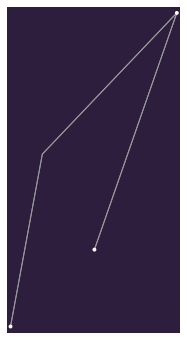

Index(['109 Tedingerbroek'], dtype='object', name='neigb')


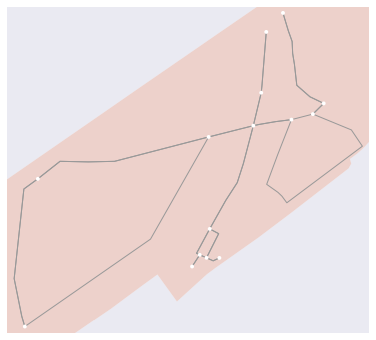

Index(['62 Rivierenbuurt-Zuid'], dtype='object', name='neigb')


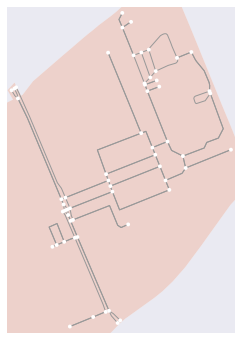

Index(['101 Erasmus Veld'], dtype='object', name='neigb')


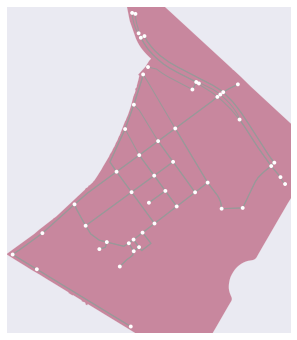

Index(['72 Rijslag'], dtype='object', name='neigb')


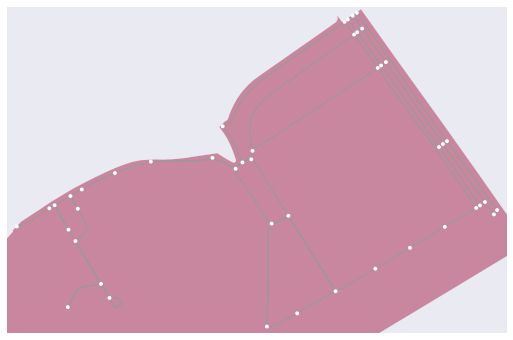

Index(['78 Arendsdorp'], dtype='object', name='neigb')


In [36]:
#To plot the geometries with the smaller length of bike lanes 
polygon=smaller_bk['geometry']
for pol in polygon:
    fig, ax = plt.subplots(1, figsize=(10, 6))
    smaller_bk.plot(column='CO2', scheme='equal_interval', k=4, cmap=sns.cubehelix_palette(as_cmap=True), alpha=1, edgecolor='w', linewidth=0.1, ax=ax) 
    G = ox.graph_from_polygon(pol, network_type ='bike')
    ox.plot_graph(G, ax=ax)
    print(smaller_bk.index[smaller_bk.geometry == pol])

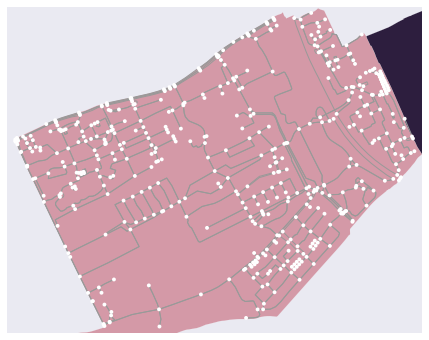

Index(['97 Kraayenstein & Vroondaal'], dtype='object', name='neigb')


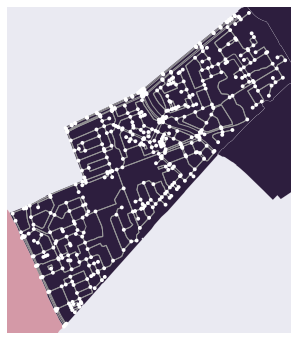

Index(['86 Houtwijk'], dtype='object', name='neigb')


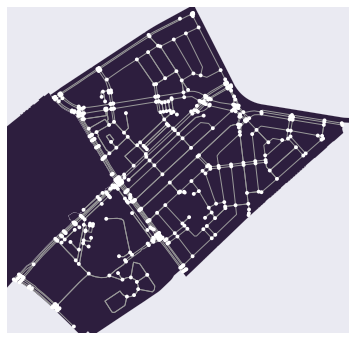

Index(['84 Leyenburg'], dtype='object', name='neigb')


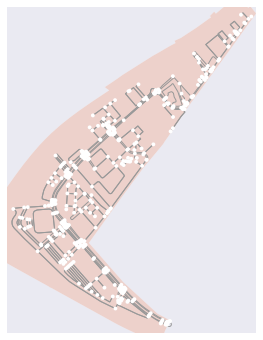

Index(['117 De Rivieren'], dtype='object', name='neigb')


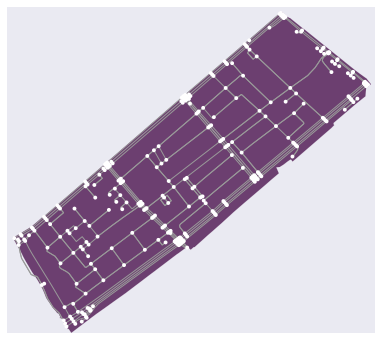

Index(['98 Dreven en Gaarden'], dtype='object', name='neigb')


In [37]:
#To plot the geometries with the bigger length of bike lanes 
polygon=larger_bk['geometry']
for pol in polygon:
    fig, ax = plt.subplots(1, figsize=(10, 6))
    larger_bk.plot(column='CO2', scheme='equal_interval', k=5, cmap=sns.cubehelix_palette(as_cmap=True), alpha=1, edgecolor='w', linewidth=0.1, ax=ax) 
    G = ox.graph_from_polygon(pol, network_type ='bike')
    ox.plot_graph(G, ax=ax)
    print(larger_bk.index[larger_bk.geometry == pol])

Looking at the geometries plotted above I have not only cases that agree with my hypothesis but also cases that refute it. Taking this into account, I would select neighbourhoods that fit into the both cases, for further analysis and to understand why that is.

Analysing each case:

For the neighbourhoods with the smaller length of bike lanes:
 * `109 Tedingerbroek` - high CO2 emission and average income -> somewhat in accordance with my hypotesis.
 
 * `62 Rivierenbuurt-Zuid` - low CO2 emission and low income (even with the smaller amount of bike lanes -> in accordance with my hypotesis(except for the bike lanes parameter).
 
 * `101 Erasmus Veld`- low CO2 emission and average income
 
 * `72 Rijslag` - considerable CO2 emission and high income -> in accordance with my hypotesis (except for the bike lanes parameter).
 
 * `78 Arendsdorp` - considerable CO2 emission and much higher income -> in accordance with my hypotesis (except for the bike lanes parameter).
 

For the neighbourhoods with the higher length of bike lanes:
 * `97 Kraayenstein & Vroondaal` - low/medium CO2 emission and average income -> somewhat in accordance with my hypotesis.
 
 * `86 Houtwijk` - high CO2 emission and average income -> not valid for the bike lane parameter.
 
 * `84 Leyenburg` - high CO2 emission and average income -> not valid for the bike lane parameter.
 
 * `117 De Rivieren` - low CO2 emission and average income -> in accordance with my hypotesis.
 
 * `98 Dreven en Gaarden` - considerable CO2 emission and low income -> refutes my hypothesis.


In [38]:
interesting_neigbs

[Index(['46 Archipelbuurt', '07 Statenkwartier', '09 Vogelwijk'], dtype='object', name='neigb'),
 Index(['71 Belgisch Park', '03 Scheveningen Badplaats', '53 Vruchtenbuurt',
        '66 Bezuidenhout-Oost'],
       dtype='object', name='neigb')]

I could only choose to analyse the neighbourhoods present in **interesting_neigbs** list (the ones that support my first hypothesis), however I would also want to analyse the cases that go against it and against the hypothesis complemented with the bike lane length, in order to understand what other factors are behind it.

Taking that into account I would choose the following neighbourhoods to do a further analysis:
* `07 Statenkwartier` (from **interesting_neigbs** list, Much Higher Income)
* `71 Belgisch Park` (from **interesting_neigbs** list, Higher Income)
* `62 Rivierenbuurt-Zuid` (in accordance with my hypotesis, except for the bike lanes parameter)
* `117 De Rivieren` (in accordance with my hypothesis)
* `98 Dreven en Gaarden` (refutes my hypothesis)

#### Global Spatial autocorrelation - Moran's I

I decided to proceed with an analysis to the global spacial autocorrelation.

In [39]:
# Create the spatial weights matrix
w = weights.Queen.from_dataframe(data)

In [40]:
mi = esda.Moran(data['CO2'], w)

To retrieve the value of the statistic:

In [41]:
mi.I

0.11447481515470756

In [42]:
mi.p_sim

0.031

By standard terms, 3.3% would be considered statistically significant, which means that, if we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, 3.3% of them would display a larger (absolute) value than the one we obtain from the real data, and the other 96.7% of the random maps would receive a smaller (absolute) value of Moran's I. Since the value of Moran's I can be interpreted as the slope of the Moran Plot, in this case, the particular spatial arrangement of values for the CO2 emission are more or less concentrated than if the values had been allocated following a completely spatially random process - that is why we have a statistical significance.

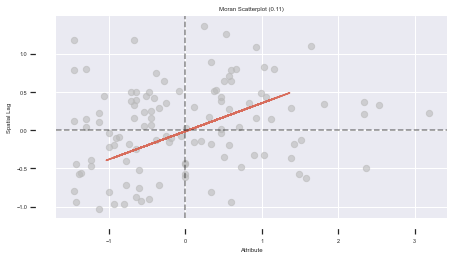

In [43]:
moran_scatterplot(mi);

Looking at the global autocorrelation analysis, the observations do seem to be positively correlated over space. Even though I was expecting a more structured pathern. I even consider if the CO2 emission shows a pattern over space at all and if it's not a random one. I would proceed with a local spacial autocorrelation.

# Assignment 3


# ``Analysis for Assignment 3``

In [365]:
#Imports the necessary libraries
import os             
import pandas as pd
import numpy as np
import palettable as pltt
import seaborn as sns
import matplotlib.pyplot as plt
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

import osmnx as ox, geopandas as gpd
%matplotlib inline
ox.config(log_console=True, use_cache=True)

import matplotlib.style as style 
style.use('seaborn-colorblind') 

Taking into account the EDA performed in assignment 2 (cells [21] - [29]).

I chose the regression path to perform my analysis for this assignment. I went through the different types of regressions in order to try to find the one that would be more adequate to my model.

In [366]:
#To define the x and y train to be used in the regression
x_train = np.asarray(data['income'])
y_train = np.asarray(data['CO2'])

In [367]:
#To check the array's shapes
print('x train shape:', x_train.shape)
print('y train shape:',y_train.shape)

x train shape: (114,)
y train shape: (114,)


In [368]:
#Reshapes the x and y trains to a shape that enables to do the regression
x_train = x_train.reshape(x_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

print('x train shape:', x_train.shape)

x train shape: (114, 1)


After obtaining the values to use in the regression, I experimented with the library `statsmodel` and `sklearn`:

In [369]:
import statsmodels.api as sm

In [370]:
#Creates the X matrix and appends a column of ones to x_train
X = sm.add_constant(x_train)

#To build the OLS model (ordinary least squares) 
toyregr_sm = sm.OLS(y_train, X)

#To fit and save regression info in results_sm
results_sm = toyregr_sm.fit()

#To get the beta parameters
beta0_sm = results_sm.params[0]
beta1_sm = results_sm.params[1]

print(f'The regression coef from statsmodels are: beta_0 = {beta0_sm:8.8f} and beta_1 = {beta1_sm:8.8f}')

The regression coef from statsmodels are: beta_0 = 6.79815674 and beta_1 = -0.00010496


In [371]:
import warnings
warnings.filterwarnings('ignore')
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     9.958
Date:                Fri, 15 Oct 2021   Prob (F-statistic):            0.00206
Time:                        11:19:35   Log-Likelihood:                -284.39
No. Observations:                 114   AIC:                             572.8
Df Residuals:                     112   BIC:                             578.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7982      0.791      8.591      0.0

<br>

Looking at the results obtained, its to notice that the R-squared is really small (0.082), demonstrating a lower correlation between the variables, which shows at first sight that my model has some issues. However, I proceeded with the analysis hoping to find some correlation between the variables.

In [372]:
from sklearn.model_selection import train_test_split

#To split into training set and testing set
traindata, testdata = train_test_split(data, test_size=0.3, random_state=42)

I chose to split the data in 30% for the test set and in 70% for the training set.

In [373]:
print("Shape of full dataset is: {0}".format(data.shape))
print("Shape of training dataset is: {0}".format(traindata.shape))
print("Shape of test dataset is: {0}".format(testdata.shape))

Shape of full dataset is: (114, 7)
Shape of training dataset is: (79, 7)
Shape of test dataset is: (35, 7)


In [374]:
#To extract the values for CO2 emissions
y_train = traindata.CO2
y_train

neigb
86 Houtwijk                  12.200000
14 Zuidwal                    7.600000
17 Schildersbuurt-Oost        5.500000
92 Bohemen/Meer en Bos        5.500000
54 Heesterbuurt               6.000000
                               ...    
114 Waterbuurt                3.700000
03 Scheveningen Badplaats     7.300000
60 Binckhorst                 0.200000
68 Marlot                     1.400000
109 Tedingerbroek             4.459091
Name: CO2, Length: 79, dtype: float64

In [375]:
#To extract the values for income
x_train = traindata.income

Just like before, the shape of the arrays had to be re-adjusted in order to make the regression possible.

In [376]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

#To reshape the x and y trains to adequate shapes
x_train = x_train.reshape(x_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

In [377]:
x_test = np.asarray(testdata.income)
y_test = np.asarray(testdata.CO2)

#To reshape the x and y test to adequate shapes
x_test = x_test.reshape(x_test.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

Then, I defined a funtion that, given a certain model, plots the prediction as well as the test data.

In [383]:
def plot_income(model, poly_transformer=None):
    
    #x values for the prediction line
    x_vals = np.arange(0,50000,1).reshape(-1,1)
    
    #To use the passed-in transformer if wanted
    if poly_transformer != None:
        dm = poly_transformer.fit_transform(x_vals)
    else:
        dm = x_vals
        
    #To predict at each x value
    prediction = model.predict(dm)
    
    ax=plt.axes()
    ax.set_facecolor("w")
    ax.spines['bottom'].set_color('0.9')
    ax.spines['left'].set_color('0.9')
    ax.spines['top'].set_color('0.9')
    ax.spines['right'].set_color('0.9')
    
    #Plot the prediction line as well as the test data
    plt.plot(x_vals, prediction, color='k', label="Prediction")
    plt.scatter(x_test, y_test, color='g', label="Test Data")

    plt.ylabel("CO2 emission", fontsize=12)
    plt.xlabel("Income", fontsize=12)
    plt.title("Income vs. CO2 emission - Linear Regression", fontsize=14)
    plt.legend()
    plt.grid(False)
    plt.show()

It was only then that I applied a linear regression to it.

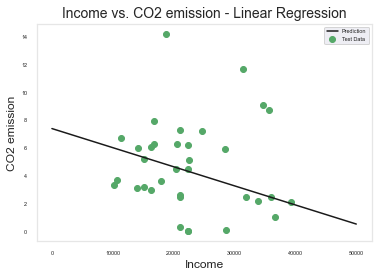

In [384]:
from sklearn.linear_model import LinearRegression
fitted_income_model0 = LinearRegression().fit(x_train, y_train)
plot_income(fitted_income_model0)

In [385]:
print('The regression coef from statsmodels are:')
print('beta_0:', fitted_income_model0.intercept_ [0])
print('beta_1:', fitted_income_model0.coef_ [0][0])

The regression coef from statsmodels are:
beta_0: 7.388837599475892
beta_1: -0.0001372012421762554


In [386]:
print("Test R-squared:", fitted_income_model0.score(x_test, y_test))

Test R-squared: -0.09237644599638761


The results were similar to the ones obtained with the other library, as expected. Once again, I was not satisfied with them since I obtained a negative value for R-squared, showing that the chosen model does not follow the trend of the data. Moreover, the overall trend is less CO2 emission for a bigger income - contrarily to my hypothesis.
<br>
<br>
Then, I used the KNeighbors regressor.

In [387]:
from sklearn.neighbors import KNeighborsRegressor

In [388]:
#To store the different regressors in a dictionary
regdict = {}

k_list = [1, 2, 4, 15]

#Do a set of KNN regressions
for k in k_list:
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(x_train, y_train)
    
    #Store the regressors in the dictionary
    regdict[k] = knnreg 

regdict

{1: KNeighborsRegressor(n_neighbors=1),
 2: KNeighborsRegressor(n_neighbors=2),
 4: KNeighborsRegressor(n_neighbors=4),
 15: KNeighborsRegressor(n_neighbors=15)}

In order to know which would be the better value for k to use, I did the following:

* First I ploted the regression for different k values to get a sense how it would fit the data.

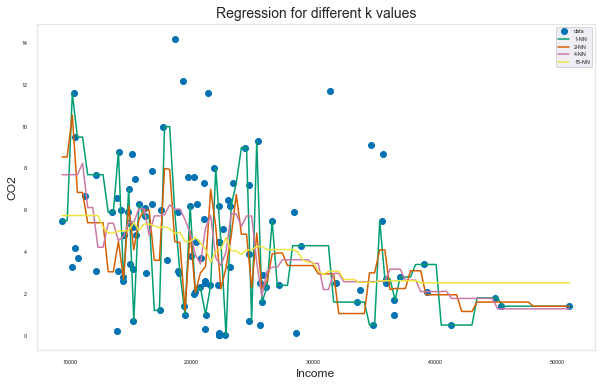

In [389]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(data.income, data.CO2, 'o', label="data")

xgrid = np.linspace(np.min(data.income), np.max(data.income), 100)

#To unpack the dictionary to its elements (k and Regressor)
for k, regressor in regdict.items():
    predictions = regressor.predict(xgrid.reshape(-1,1)) 
    ax.plot(xgrid, predictions, label="{}-NN".format(k))

ax.legend();
ax.set_xlabel('Income', fontsize=12)
ax.set_ylabel('CO2', fontsize=12)

ax.set_title('Regression for different k values', fontsize=14) 

ax.grid(False)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('0.9')
ax.spines['left'].set_color('0.9')
ax.spines['top'].set_color('0.9')
ax.spines['right'].set_color('0.9')

for txt in fig.texts:
    txt.set_visible(False)

* Then, I ploted the R-squared scores for different values of k in order to find the one that would translate to a bigger R-squared.

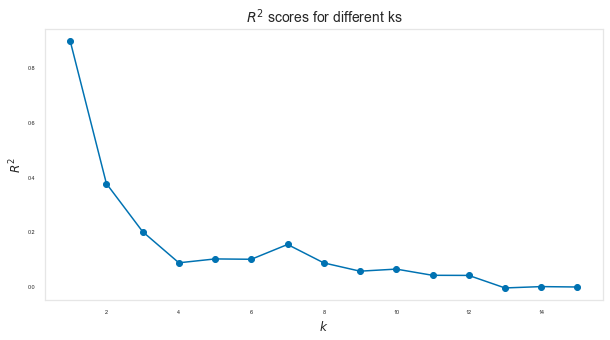

In [390]:
ks = range(1, 16)

scores_train = [] #R2 scores

for k in ks:
    
    #To create KNN model
    knnreg = KNeighborsRegressor(n_neighbors=k) 
    
    #To fit the model to test data
    knnreg.fit(x_test, y_test) 
    
    #To calculate R^2 score
    score_train = knnreg.score(x_test, y_test) 
    scores_train.append(score_train)

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(ks, scores_train,'o-')
ax.set_xlabel(r'$k$', fontsize=12)
ax.set_ylabel(r'$R^{2}$', fontsize=12)

ax.set_title(r'$R^{2}$ scores for different ks', fontsize=14)

ax.grid(False)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('0.9')
ax.spines['left'].set_color('0.9')
ax.spines['top'].set_color('0.9')
ax.spines['right'].set_color('0.9')


for txt in fig.texts:
    txt.set_visible(False)

Taking the plot above into account, I chose the k with a higher R-squared after k=1: `k=2`.

In [391]:
k = 2 
knnreg = KNeighborsRegressor(n_neighbors=k)

In [392]:
#To fit the regressor
knnreg.fit(x_train, y_train)

#To evaluate the outcome on the train set using R^2
r2_train = knnreg.score(x_train, y_train)

print(f'kNN model with {k} neighbors gives R^2 on the train set: {r2_train:.5}')

kNN model with 2 neighbors gives R^2 on the train set: 0.47426


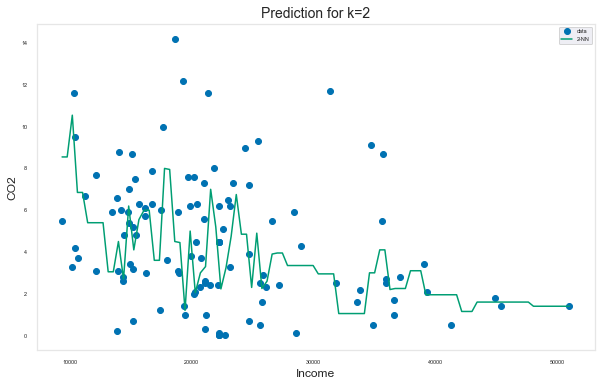

In [393]:
#To plot the prediction using k=2
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(data.income, data.CO2, 'o', label="data")

xgrid = np.linspace(np.min(data.income), np.max(data.income), 100)

prediction = knnreg.predict(xgrid.reshape(-1,1)) 

ax.plot(xgrid, prediction, label="2-NN")

ax.legend()
ax.set_xlabel('Income', fontsize=12)
ax.set_ylabel('CO2', fontsize=12)

ax.set_title('Prediction for k=2', fontsize=14) 

ax.grid(False)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('0.9')
ax.spines['left'].set_color('0.9')
ax.spines['top'].set_color('0.9')
ax.spines['right'].set_color('0.9')

for txt in fig.texts:
    txt.set_visible(False)

When using this regressor I obtained a bigger R-squared comparing to the others and, indeed, as is possible to see in the plot above, the tendency is a smaller CO2 emission for a bigger income.

<br>

Since the previous regressions didn't correspond to what I was expecting, I proceeded with a polynomial fit.

In [394]:
from sklearn.preprocessing import PolynomialFeatures

transformer_2 = PolynomialFeatures(2, include_bias=False)
expanded_train = transformer_2.fit_transform(x_train) 
pd.DataFrame(expanded_train).describe()

,0,1
count,79.000000,7.900000e+01
mean,22137.019346,5.620434e+08
std,8539.247765,4.790103e+08
min,9400.000000,8.836000e+07
25%,15450.000000,2.387050e+08
50%,20800.000000,4.326400e+08
75%,25100.000000,6.301700e+08
max,51000.000000,2.601000e+09


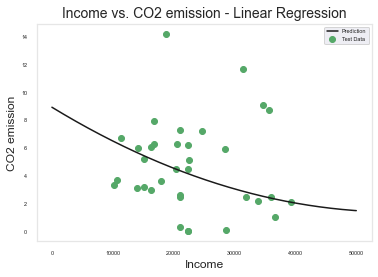

In [395]:
fitted_income_model2 = LinearRegression().fit(expanded_train, y_train)
plot_income(fitted_income_model2, transformer_2)

In [396]:
expanded_test = transformer_2.fit_transform(x_test)
print("Test R-squared:", fitted_income_model2.score(expanded_test, y_test))

Test R-squared: -0.12061248728689589


With this transformation I obtained an even worse R-squared, comparing with the other regressions. This, once again, shows that my model needs changes. 

To measure how much the regression line misses the data points, I calculated the residual values for the last fit. Looking at the plot bellow, I corroborate that my data set is not a good fit for regression.

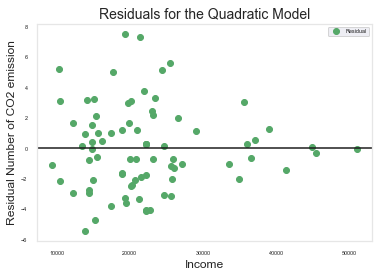

In [400]:
x_matrix = transformer_2.fit_transform(x_train)

prediction = fitted_income_model2.predict(x_matrix)
residual = y_train - prediction

#To adjust the looks of the plot
ax=plt.axes()
ax.set_facecolor("w")
ax.spines['bottom'].set_color('0.9')
ax.spines['left'].set_color('0.9')
ax.spines['top'].set_color('0.9')
ax.spines['right'].set_color('0.9')

plt.scatter(x_train, residual, label="Residual", color='g')
plt.axhline(0, color='k')

plt.title("Residuals for the Quadratic Model", fontsize=14)
plt.ylabel("Residual Number of CO2 emission", fontsize=12)
plt.xlabel("Income", fontsize=12)
plt.grid(False)

plt.legend()

for txt in fig.texts:
    txt.set_visible(False)

**Analysis using `bike_lane_length` variable**

Similarly to what I have done for assignment 2, I decided to include in my model the variable for the bike lanes length, in order to find if it could also be related to the CO2 emissions. I hypothesized that a bigger length of bike lanes would translate in a smaller CO2 emission.
<br>
I also did a regression analysis for this variables.

This time, I only performed a linear regression using the `sklearn` library.
<br>
`y_train` (CO2 emission) will be the same and `x_train` will correspond to the one defined bellow:

In [354]:
x_train = traindata.bike_lanes_length

In [355]:
x_train = np.asarray(x_train)

#To reshape the x train to adequate shapes (y is already adjusted)
x_train = x_train.reshape(x_train.shape[0], 1)

In [356]:
x_test = np.asarray(testdata.bike_lanes_length)

#To reshape the x test to adequate shapes
x_test = x_test.reshape(x_test.shape[0], 1)

As for the other elements of the regression analysis I proceeded similarly to what I've done for the income.

In [404]:
def plot_bike(model, poly_transformer=None):
    
    #x values for the prediction line
    x_vals = np.arange(0,42000,1).reshape(-1,1)
    
    # optionally use the passed-in transformer
    if poly_transformer != None:
        dm = poly_transformer.fit_transform(x_vals)
    else:
        dm = x_vals
        
    #To predict at each x value
    prediction = model.predict(dm)
    
    ax=plt.axes()
    ax.set_facecolor("w")
    ax.spines['bottom'].set_color('0.9')
    ax.spines['left'].set_color('0.9')
    ax.spines['top'].set_color('0.9')
    ax.spines['right'].set_color('0.9')
    
    #Plot the prediction line as well as the test data
    plt.plot(x_vals, prediction, color='k', label="Prediction")
    plt.scatter(x_test, y_test, color='y', label="Test Data")

    plt.ylabel("CO2 emission", fontsize=12)
    plt.xlabel("Bike lane length", fontsize=12)
    plt.title("Bike lane length vs. CO2 emission - Linear Regression", fontsize=14)
    plt.legend()
    plt.grid(False)
    plt.show()

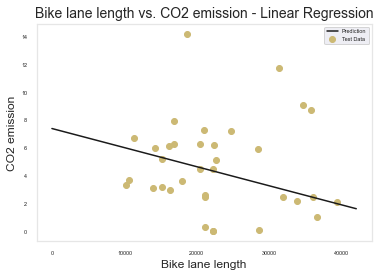

In [405]:
fitted_bike_model0 = LinearRegression().fit(x_train, y_train)
plot_bike(fitted_bike_model0)

In [406]:
print('The regression coef from statsmodels are:')
print('beta_0:', fitted_bike_model0.intercept_ [0])
print('beta_1:', fitted_bike_model0.coef_ [0][0])

The regression coef from statsmodels are:
beta_0: 7.388837599475892
beta_1: -0.0001372012421762554


In [407]:
print("Test R-squared:", fitted_bike_model0.score(x_test, y_test))

Test R-squared: -0.09237644599638761


On the one hand, the R-squared for this two variables is better, even tho it remains smaller than I would expect. On the other hand, the fit represents completety the opposite of what I was expecting, with a relative increase of CO2 emissions with the bike lane length.

Then, I did a polynomial fit - chose a fit of order 2 after trial and error.

In [408]:
transformer_2 = PolynomialFeatures(2, include_bias=False)
expanded_train = transformer_2.fit_transform(x_train) 
pd.DataFrame(expanded_train).describe()

,0,1
count,79.000000,7.900000e+01
mean,22137.019346,5.620434e+08
std,8539.247765,4.790103e+08
min,9400.000000,8.836000e+07
25%,15450.000000,2.387050e+08
50%,20800.000000,4.326400e+08
75%,25100.000000,6.301700e+08
max,51000.000000,2.601000e+09


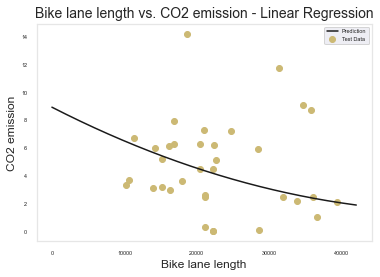

In [409]:
fitted_bike_model2 = LinearRegression().fit(expanded_train, y_train)
#print("fitting expanded_train:", expanded_train)
plot_bike(fitted_bike_model2, transformer_2)

In [410]:
expanded_test = transformer_2.fit_transform(x_test)
print("Test R-squared:", fitted_bike_model2.score(expanded_test, y_test))

Test R-squared: -0.12061248728689589


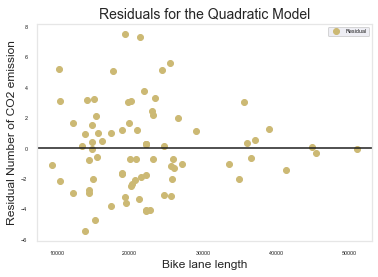

In [412]:
x_matrix = transformer_2.fit_transform(x_train)

prediction = fitted_bike_model2.predict(x_matrix)
residual = y_train - prediction

ax=plt.axes()
ax.set_facecolor("w")
ax.spines['bottom'].set_color('0.9')
ax.spines['left'].set_color('0.9')
ax.spines['top'].set_color('0.9')
ax.spines['right'].set_color('0.9')

plt.scatter(x_train, residual, label="Residual", color='y')
plt.axhline(0, color='k')

plt.title("Residuals for the Quadratic Model", fontsize=14)
plt.ylabel("Residual Number of CO2 emission", fontsize=12)
plt.xlabel("Bike lane length", fontsize=12)
plt.grid(False)
plt.legend()

for txt in fig.texts:
    txt.set_visible(False)

To measure how much the regression line misses the data points, I calculated the residual values for the last fit and, once again, by looking at the plot above, I corroborate that my data set is not a good fit for regression. However, the R-squared values obtained for this variable are bigger and therefore I have more trust in the results obtained for this regressions than the others.

### **Comment**

After completing this analysis, I conclude that my model needs changes. Many issues could have been the reason why: for example, the variable I chose from Den Haag Cifjers for the CO2 emission could have been wrongly interpreted by me and represent a different CO2 emission and, therefore, not be as related to the income as I would think. The same for the bike lanes lenght. To try to solve it I would first try to look for similar variables (in different databases for example) and if that ends up not solving it, I would go towards a whole different direction and even change my hypothesis. For instance, all the variables revealed to correlate more or less in the opposite way I was expecting them to, revealing that probably there are other variables contributing to this observations. For example, I didn't take into acccount that a more urbanized neighbourhood (with more roads and therefore more prone to emit CO2) is probably accompanied with a bigger bike network. For a further analysis, I could include other variables, such as:

* `Bike use per neighbourhood`
* `Motor vehicles use or possession per neighbourhood`
* `Amount of Roads per neighbourhood`